interactive(children=(FloatSlider(value=0.0, description='drive', max=1.0), FloatSlider(value=0.0, description…

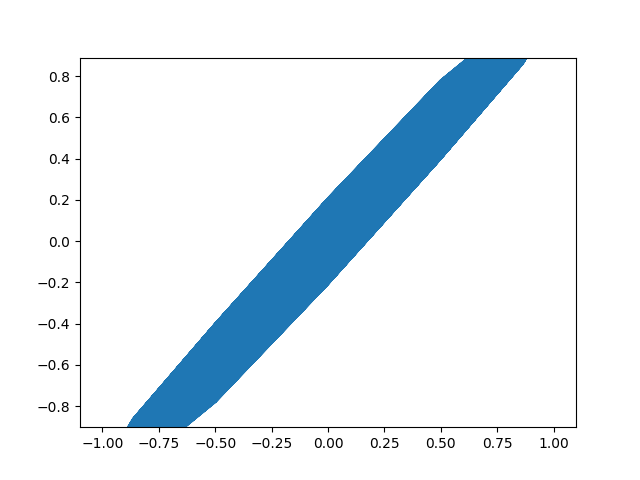

In [10]:
%matplotlib ipympl
import math
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt


fs = 48000

def interpolate(x, a, b):
    return (1 - x) * a + x * b


def sat_antiderivative(drive, blend):
    a = (1.0 + drive) * (1.0 + drive) * (1.0 + drive) - 0.999

    def f(input):
        if (input >= 0.0):
            return ((1 + a) * (a * input - math.log(1 + a * input))) / (a * a)
        else:
            return ((1 + a) * (a * input * (-2 + blend * (2 + a * input)) + 2 * (-1 + blend) * math.log(1 - a * input))) / (2 * a * a)

    return f


def sat_function(drive, blend):
    a = (1.0 + drive) * (1.0 + drive) * (1.0 + drive) - 1.0

    def f(input):
        if (input >= 0.0):
            return (1.0 + a) * input / (1.0 + a * input)
        else:
            symetric = (1.0 + a) * input / (1.0 - a * input)
            assymetric = input * (a + 1.0)
            return interpolate( blend, symetric, assymetric)

    return f


def dc_filter(freq):
    r = 1.0 - (math.pi * 2.0 * freq / fs);
    x1 = 0.0
    y1 = 0.0

    def f(x):
        nonlocal x1, y1
        y = x - x1 + r * y1
        x1 = x
        y1 = y
        return y
    return f


# trapezoidal rule derivative, alpha = 1
def deriv (x_n, x_n1, xDeriv_n1, T):
    return (((1 + 1) / T) * (x_n - x_n1)) - xDeriv_n1


alpha = 1.6e-3

def hysteresis_function (hyst):
    T = 1/fs
    c = (1 - hyst)

    prev_output = 0
    prev_input = 0
    prev_input_deriv = 0

    def f(input):
        nonlocal prev_output, prev_input, prev_input_deriv
        input_deriv = deriv (input, prev_input, prev_input_deriv, T)

        smoothed_input = (input + prev_input) / 2
        smoothed_input_deriv = (input_deriv + prev_input_deriv) / 2

        diff = smoothed_input + alpha * prev_output - prev_output
        delta = 1 if smoothed_input_deriv > 0 else -1
        delta_M = 1 if np.sign (delta) == np.sign (diff) else 0
        # output = prev_output + T * (((1 - c) * delta_M * diff / ((1 - c) * delta - alpha * diff)) * smoothed_input_deriv + c * smoothed_input_deriv)
        output = prev_output + T * ((delta_M * diff / (delta)) * smoothed_input_deriv + c * smoothed_input_deriv)

        prev_output = output
        prev_input = input
        prev_input_deriv = input_deriv

        return output

    return f


def abomination(drive, blend, hyst):
    # return sat_function(drive, blend)
    adf = sat_antiderivative(drive, blend)

    dcf = dc_filter(24.0)

    m = 1 + 1.5 * hyst * hyst
    hysteresis = hysteresis_function(hyst)

    prev_sample = 0.0
    prev_saturated = 0.0

    def f(sample):
        nonlocal prev_sample, prev_saturated
        saturated = 0.0
        if sample == prev_sample:
            saturated = prev_saturated
        else:
            saturated = (adf (sample) - adf (prev_sample)) / (sample - prev_sample)

        a = (1.0 + drive) * (1.0 + drive) * (1.0 + drive) - 0.999
        saturated = saturated / interpolate(blend, 3.0 * drive + 1.0, a / 2.0 + 1.0)

        prev_sample = sample
        prev_saturated = saturated
        return dcf(m * hysteresis(saturated))

    return f


def rising_sine_response (func, freq=500, seconds=0.2):
    N = fs * seconds
    n = np.arange (N)
    x = np.sin (2 * np.pi * n * freq / fs) * (n/N)
    y = np.array([func(sample) for sample in x])
    return x, y


fig = plt.figure()
sp = fig.add_subplot(1, 1, 1)
# x, y = rising_sine_response(nebula_saturation(0.0, 0.0, 0.0))
x, y = rising_sine_response(abomination(0.1, 0.1, 0.1), freq=4000)
# x, y = rising_sine_response(mu(), freq=100)
line, = sp.plot (x, y)


def update(drive = 0.0, blend = 0.0, hysteresis = 0.0):
    _, y = rising_sine_response(abomination(drive, blend, hysteresis), freq=4000)
    # _, y = rising_sine_response(mu(), freq=100)
    line.set_ydata(y)
    fig.canvas.draw_idle()

interact(update);